In [5]:
# Install required libraries (run once) - Already done, but confirm
!pip install pandasql pyspark

In [6]:
# Import libraries (same as before)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandasql as ps  # For SQL queries
from pyspark.sql import SparkSession  # For big data simulation
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression as SparkLR
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive (optional, for saving outputs to simulate cloud storage like Azure)
from google.colab import drive
drive.mount('/content/drive')

# Upload the zip file from your computer
from google.colab import files
print("Please upload archive.zip from your computer")
uploaded = files.upload()  # This opens a file picker; select archive.zip

# Unzip the archive
import zipfile
zip_path = '/content/archive.zip'  # Path where Colab stores uploaded files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Extracts to /content/

# Load the CSV
csv_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(csv_path)

# Basic info: Shape, columns, first few rows
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please upload archive.zip from your computer


Saving archive.zip to archive (1).zip
Dataset Shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...     

In [4]:
# SQL Query Examples using pandasql
# Query 1: Count churn by gender
q1 = "SELECT gender, COUNT(*) as count, AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as churn_rate FROM df GROUP BY gender"
result1 = ps.sqldf(q1)
print("Churn Rate by Gender:\n", result1)

# Query 2: Average tenure and monthly charges for churned vs non-churned
q2 = "SELECT Churn, AVG(tenure) as avg_tenure, AVG(MonthlyCharges) as avg_monthly FROM df GROUP BY Churn"
result2 = ps.sqldf(q2)
print("\nAvg Tenure and Charges by Churn:\n", result2)

# Query 3: Top payment methods for high-churn segments (month-to-month contracts)
q3 = """SELECT PaymentMethod, COUNT(*) as count
        FROM df WHERE Contract = 'Month-to-month' AND Churn = 'Yes'
        GROUP BY PaymentMethod ORDER BY count DESC"""
result3 = ps.sqldf(q3)
print("\nTop Payment Methods for Churned Month-to-Month Customers:\n", result3)

q4 = "SELECT InternetService, COUNT(*) as count, AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as churn_rate FROM df GROUP BY InternetService"
result4 = ps.sqldf(q4)
print("Churn Rate by InternetService:\n", result4)

Churn Rate by Gender:
    gender  count  churn_rate
0  Female   3488    0.269209
1    Male   3555    0.261603

Avg Tenure and Charges by Churn:
   Churn  avg_tenure  avg_monthly
0    No   37.569965    61.265124
1   Yes   17.979133    74.441332

Top Payment Methods for Churned Month-to-Month Customers:
                PaymentMethod  count
0           Electronic check    994
1               Mailed check    282
2  Bank transfer (automatic)    201
3    Credit card (automatic)    178
Churn Rate by InternetService:
   InternetService  count  churn_rate
0             DSL   2421    0.189591
1     Fiber optic   3096    0.418928
2              No   1526    0.074050


In [7]:
# Clean data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)  # Fix blanks
df = df.drop('customerID', axis=1)  # Drop irrelevant ID
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})  # Binary target

# Feature Engineering
df['TenureRatio'] = df['tenure'] / 12  # Years of tenure
df['HighCharge'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)  # Above-median charges
df['ServiceBundle'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']].apply(
    lambda x: sum(1 for val in x if val == 'Yes'), axis=1)  # Count active services

# Encode categorical variables
label_encoders = {}
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Handle 'No phone/internet service'
    label_encoders[col] = le

# Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Train/Test Split: ", X_train.shape, X_test.shape)

Train/Test Split:  (5634, 22) (1409, 22)


Number of high-risk customers (propensity > 0.7): 84
Proportion of test set: 5.96%
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC Score: 0.8400087834870444


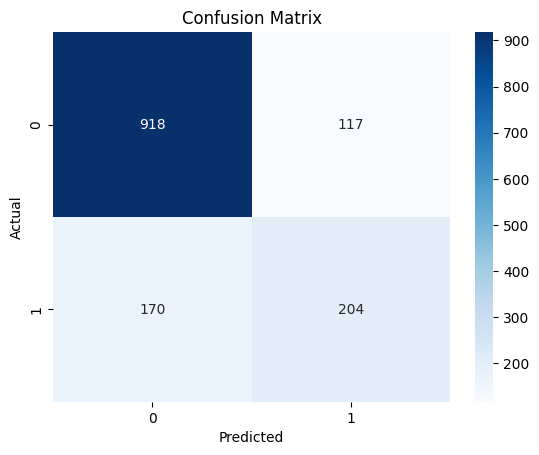

In [13]:
# Build and train model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Propensity scores

# Identify high-risk customers (propensity > 0.7)
high_risk_mask = y_pred_proba > 0.7
high_risk_count = high_risk_mask.sum()
print(f"Number of high-risk customers (propensity > 0.7): {high_risk_count}")
print(f"Proportion of test set: {high_risk_count / len(y_test):.2%}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
# Calculate potential business impact
total_customers = df.shape[0]
churn_rate = df['Churn'].mean()
total_churned = int(total_customers * churn_rate)
targeted_reduction = 0.15
customers_retained = int(total_churned * targeted_reduction)
acquisition_cost = 500  # $500 per customer
savings = customers_retained * acquisition_cost

print(f"Total Customers: {total_customers}")
print(f"Churn Rate: {churn_rate:.3f} ({total_churned} customers)")
print(f"Targeted 15% Reduction: {customers_retained} customers retained")
print(f"Estimated Savings: ${savings:,} (at $500/customer acquisition cost)")

# Update recommendation based on calculation
print(f"\nRecommendation: Launch retention campaign targeting high-risk segments with a {targeted_reduction}% discount. This could retain {customers_retained}, saving ${savings}.")

Total Customers: 7043
Churn Rate: 0.265 (1869 customers)
Targeted 15% Reduction: 280 customers retained
Estimated Savings: $140,000 (at $500/customer acquisition cost)

Recommendation: Launch retention campaign targeting high-risk segments with a 0.15% discount. This could retain 280, saving $140000.


In [9]:
# Initialize Spark
spark = SparkSession.builder.appName("ChurnAnalysis").getOrCreate()

# Load to Spark DataFrame
spark_df = spark.createDataFrame(df)
spark_df = spark_df.withColumn("Churn", spark_df.Churn.cast("integer"))

# Prepare features with VectorAssembler
feature_cols = [col for col in spark_df.columns if col != "Churn"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(spark_df)

# Train Spark Logistic Regression
lr_spark = SparkLR(featuresCol="features", labelCol="Churn")
model_spark = lr_spark.fit(assembled_df)

# Evaluate
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Churn")
auc = evaluator.evaluate(model_spark.transform(assembled_df))
print("Spark ROC AUC:", auc)

spark.stop()
print("PySpark simulation complete – handles distributed processing.")

Spark ROC AUC: 0.8472433265640861
PySpark simulation complete – handles distributed processing.


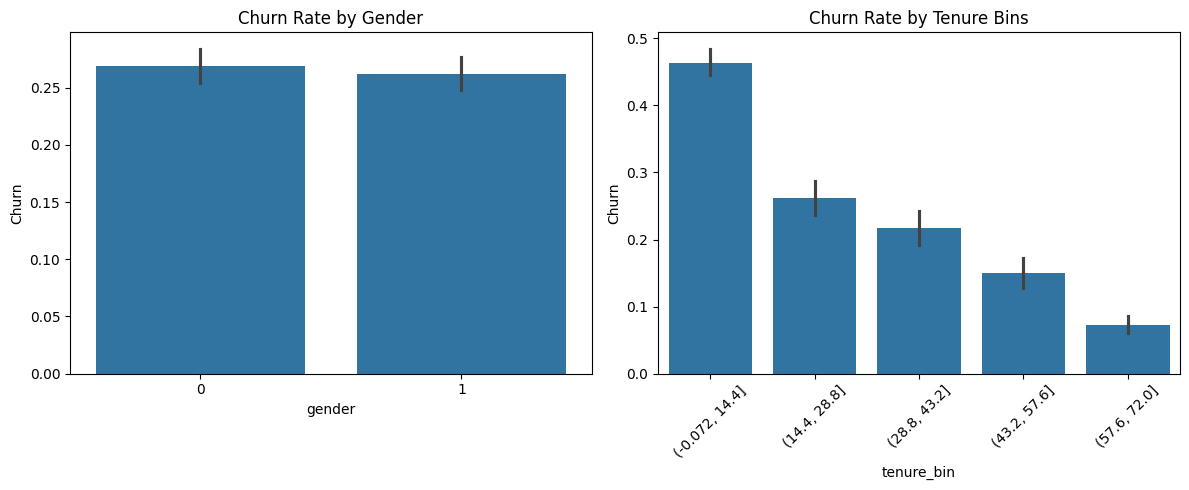

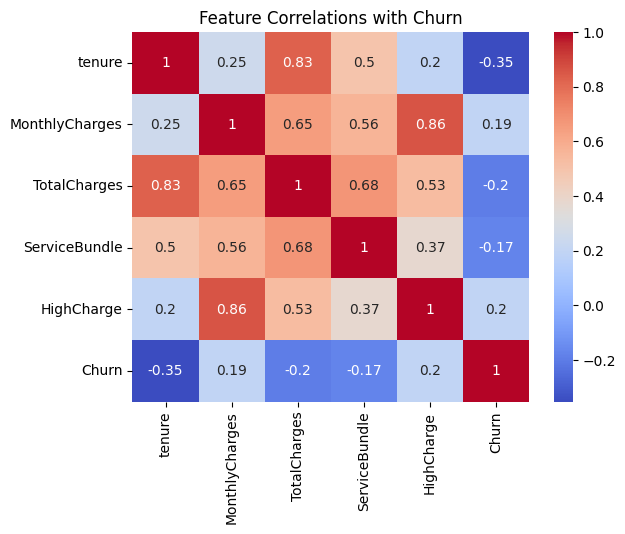

In [10]:
# Visualize trends
plt.figure(figsize=(12, 5))

# Churn by gender
plt.subplot(1, 2, 1)
sns.barplot(data=df, x='gender', y='Churn')
plt.title('Churn Rate by Gender')

# Churn by tenure (binned)
df['tenure_bin'] = pd.cut(df['tenure'], bins=5)
plt.subplot(1, 2, 2)
sns.barplot(data=df, x='tenure_bin', y='Churn')
plt.title('Churn Rate by Tenure Bins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceBundle', 'HighCharge', 'Churn']
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations with Churn')
plt.show()